In [116]:
import numpy as np
import copy
from matplotlib import pyplot as plt

In [117]:
#BGA Implementation - Data Structure
class Chromosome:
    def __init__(self,dim,lengtharr=None,bounds=None):
        self.dim =dim;
        if lengtharr is None or len(lengtharr)!=self.dim:
            self.lengtharr = [4]*self.dim;
        else:
            self.lengtharr = lengtharr;
        if bounds is None or len(bounds)!=self.dim:
            self.bounds = [(-10,10)]*self.dim;
        else:
            self.bounds = bounds;
        self.arr = [np.zeros((self.lengtharr[j],)) for j in range(dim)];
    def setmember(self,stringarr,i):
        self.arr[i] = stringarr[0:self.lengtharr[i]].flatten();
    def getdecimal(self,i):
        return self.bounds[i][0] +  (self.bounds[i][1]-self.bounds[i][0])/(2**self.lengtharr[i]-1)*int("".join((self.arr[i].astype(int)).astype(str)),2)
class Binary_Individual:
    def __init__(self,dim,lengtharr,bounds):
        self.dim=dim;
        self.lengtharr = lengtharr;
        self.bounds=bounds;
        self.chromosome = Chromosome(self.dim,self.lengtharr,self.bounds);
        self.lengtharr=self.chromosome.lengtharr;
        self.bounds=self.chromosome.bounds;
        self.fitness = 0;
        self.xbin = np.zeros((self.dim,));
    def setmembers(self,arr):
        for i in range(self.dim):
            self.chromosome.setmember(arr[i,:],i);
            self.xbin[i] = self.chromosome.getdecimal(i);
class Binary_Population:
    def __init__(self,size,dim,lengtharr=None,bounds=None):
        self.size = size
        self.dim = dim;
        self.lengtharr=lengtharr;
        self.bounds=bounds;
        self.popu = [Binary_Individual(self.dim,self.lengtharr,self.bounds) for num in range(self.size)];
        self.lengtharr=self.popu[0].lengtharr;
        self.bounds=self.popu[0].bounds;
    def initialize(self):
        randarr = np.random.binomial(1,0.5,(self.size,self.dim,max(self.lengtharr)));
        for i in range(self.size):
            self.popu[i].setmembers(np.array(randarr[i]))
    def print_pop(self):
        for i in range(self.size):
            print("Individual " + str(i+1) + " ------------------>")
            print("Binary :")
            print("[", end="");
            for j in range(self.dim-1):
                print(self.popu[i].chromosome.arr[j]);
            print(self.popu[i].chromosome.arr[self.dim-1],end="")
            print("]");
            print("Decimal :")
            print(self.popu[i].xbin)
    def evaluate_pop(self,func,flag=0):
        obj = np.array([]);
        for i in range(self.size):
            self.popu[i].fitness = func(self.popu[i].xbin);
            obj = np.append(obj,self.popu[i].fitness)
        if flag==1:
            print("Fitness of Population : " + str(obj));
        if flag==-1:
            pass
        else:
            return obj;
        
    def update_values(self,func):
        for ind1 in range(self.size):
            for ind in range(self.dim):
                self.popu[ind1].xbin[ind] = self.popu[ind1].chromosome.getdecimal(ind);
        self.evaluate_pop(func,-1);

In [118]:
#Test Block

# a = np.array([1,2,3,4,5,6,7,8,9,10]);
# "".join(a.astype(str))
# a=[None]*3;
# a[1]=2
# print(a)

def func(x):
    return np.sum(x**2 - 10*np.cos(2*np.pi*x)) + 10*len(x);


In [119]:
#BGA Implementation - Algorithms

def bga(size=20,dim=10,lengtharr=None,bounds=None,pc=1.0,pm=0.1,T=500,func=func):
    if lengtharr is None:
        lengtharr =[10]*dim
    if bounds is None:
        bounds= [(-10,10)]*dim;
    b=Binary_Population(size,dim,lengtharr,bounds)
    b.initialize();
    # b.print_pop();
    # b.evaluate_pop(func,1);


    # b.evaluate_pop(func,1)
    printflag=-1;

    bestfit = np.array([]);

    for iter in range(T):

        #Selection - Binary Tournament -----------------------------------------------------------------
        print("Generation :" + str(iter));
    #     b.print_pop();
        print("---####################################################################################----")
        fitness = b.evaluate_pop(func)
    #     print("FIT : " + str(fitness))
        out = np.array([]);
        indices = np.random.permutation(np.arange(b.size))
        indices2 = np.random.permutation(np.arange(b.size))
        for i in range(0,b.size-b.size%2,2):
            out=np.append(out,indices[i+np.argmin(fitness[indices[i:i+2]])])
            out=np.append(out,indices2[i+np.argmin(fitness[indices2[i:i+2]])])
        if b.size%2:
            out=np.append(out,indices[-1] + (indices2[-1] - indices[-1])*np.argmin(fitness[np.append(indices[b.size-1], indices2[b.size-1])]))
        out = out.astype(int)
    #     print(out)
        # print("----------------------------------------------")
        # print(b.popu)
        # print("----------------------------------------------")
        c=copy.deepcopy(b);
        c.evaluate_pop(func,1);
        for i in range(b.size):
            b.popu[i] = copy.deepcopy(c.popu[out[i]]);
    #     print(b.popu)
    #     print(c.popu)
        # print("----------------------------------------------")

    #     print("After selection")
    #     printflag=1;
        b.update_values(func);
        b.evaluate_pop(func,printflag);
        c=copy.deepcopy(b);

        #Variation - Crossover -----------------------------------------------------------------
        crossover_type = 0;
        indices = np.random.permutation(np.arange(b.size))
        #     print(indices);
        #     indices = (np.array(out[indices])).astype(int);
        #     print(indices);
        flag = np.random.rand(b.size//2); 
        for i in range(b.size//2):
            if flag[i]<=pc:
                if crossover_type == 0:
                    for j in range(b.dim):
                        rand_crossover = np.random.binomial(1,0.5,(b.lengtharr[j]));
                        temp = (1-rand_crossover)*b.popu[indices[2*i]].chromosome.arr[j] + (rand_crossover)*b.popu[indices[2*i+1]].chromosome.arr[j];
                        b.popu[indices[2*i+1]].chromosome.arr[j] = (1-rand_crossover)*b.popu[indices[2*i+1]].chromosome.arr[j] + (rand_crossover)*b.popu[indices[2*i]].chromosome.arr[j];
                        b.popu[indices[2*i]].chromosome.arr[j] = temp;
                else:
                    for j in range(b.dim):
                        rand_crossover = np.random.randint(b.lengtharr[j]);
                        temp = b.popu[indices[2*i]].chromosome.arr[j];
                        b.popu[indices[2*i]].chromosome.arr[j][rand_crossover:] = b.popu[indices[2*i+1]].chromosome.arr[j][rand_crossover:]
                        b.popu[indices[2*i+1]].chromosome.arr[j][rand_crossover:] = temp[rand_crossover:]
    #     print("After crossover")
        b.update_values(func);
        b.evaluate_pop(func,printflag); 

        #Variation - Bitwise Mutation -----------------------------------------------------------------

        for i in range(b.size):
            if np.random.rand()<=pm:
                for j in range(b.dim):
                    mutate_ind = np.random.randint(b.lengtharr[j])
                    b.popu[i].chromosome.arr[j][mutate_ind]=1-b.popu[i].chromosome.arr[j][mutate_ind];

    #     print("After ,mutation")
        b.update_values(func);
        b.evaluate_pop(func,printflag);

        #Survival - mu + lambda -----------------------------------------------------------------------

        fitarr = np.array([]);
        indexarr = np.arange(b.size*2);
        for i in range(b.size*2):
            if i<b.size:
                fitarr = np.append(fitarr,c.popu[i].fitness);
            else:
                fitarr = np.append(fitarr,b.popu[i-b.size].fitness);

        sorted_ind = np.argsort(fitarr);
        fitarr = fitarr[sorted_ind];
        indexarr = indexarr[sorted_ind];
    #     print(fitarr)
        offspring = copy.deepcopy(b);
        for i in range(b.size):
            if indexarr[i]<b.size:
                offspring.popu[i] = copy.deepcopy(c.popu[indexarr[i]])
            else:
                offspring.popu[i] = copy.deepcopy(b.popu[indexarr[i]-b.size])
        for i in range(b.size):
            b.popu[i] = copy.deepcopy(offspring.popu[i])

#         print("After survival")
        b.update_values(func);
        fitness = b.evaluate_pop(func); 
#         print("Fitness : " + str(fitness));

        bestfit = np.append(bestfit,np.amin(fitness))
        print("FIT : " + str(bestfit[-1]))
        #End of generation -----------------------------------------------------------------------------
    return bestfit

In [120]:
#RGA Implementation - Data Structure
class Real_Individual:
    def __init__(self,dim,bounds=None):
        self.dim=dim;
        if bounds is None or len(bounds) != self.dim:
            self.bounds = [(-10,10)]*self.dim;
        else:
            self.bounds=bounds;
        self.fitness = 0;
        self.x_real = np.zeros((self.dim,));
    def setmembers(self,x):
            self.x_real = x;
class Real_Population:
    def __init__(self,size,dim,bounds=None):
        self.size = size//2*2;
        self.dim = dim;
        self.bounds=bounds;
        self.popu = [Real_Individual(self.dim,self.bounds) for num in range(self.size)];
        self.bounds=self.popu[0].bounds;
    def initialize(self):
        boundarr = np.array(self.bounds);
        randarr = boundarr[:,0] + (boundarr[:,1]-boundarr[:,0])*np.random.rand(self.size,self.dim);
        for i in range(self.size):
            self.popu[i].setmembers(randarr[i,:])
    def print_pop(self):
        for i in range(self.size):
            print("Individual " + str(i+1) + " ------------------>")
            print("Decimal :")
            print(self.popu[i].x_real)
    def evaluate_pop(self,func,flag=0):
        obj = np.array([]);
        for i in range(self.size):
            self.popu[i].fitness = func(self.popu[i].x_real);
            obj = np.append(obj,self.popu[i].fitness)
        if flag==1:
            print("Fitness of Population : " + str(obj));
        if flag==-1:
            pass
        else:
            return obj;


In [121]:
a= [1,2,3,4,5]
print(a[np.array([2])[0]])
b = [(1,1),(2,2),(3,3)]
print(np.array(b))
# print(*(a+1))

3
[[1 1]
 [2 2]
 [3 3]]


In [122]:
#RGA Implementation - Algorithms

def rga(size=20,dim=10,bounds=None,pc=1.0,pm=0.1,T=500,func=func):
    if bounds is None:
        bounds=[-10,10]*dim;
    b=Real_Population(size,dim,bounds)
    b.initialize();
    # b.print_pop();
    # b.evaluate_pop(func,1);
    printflag=-1;

    bestfit = np.array([]);

    for iter in range(T):

        #Selection - Binary Tournament -----------------------------------------------------------------
        print("Generation :" + str(iter));
    #     b.print_pop();
        print("---####################################################################################----")
        fitness = b.evaluate_pop(func)
    #     print("FIT : " + str(fitness))
        out = np.array([]);
        indices = np.random.permutation(np.arange(b.size))
        indices2 = np.random.permutation(np.arange(b.size))
        for i in range(0,b.size-b.size%2,2):
            out=np.append(out,indices[i+np.argmin(fitness[indices[i:i+2]])])
            out=np.append(out,indices2[i+np.argmin(fitness[indices2[i:i+2]])])
        if b.size%2:
            out=np.append(out,indices[-1] + (indices2[-1] - indices[-1])*np.argmin(fitness[np.append(indices[b.size-1], indices2[b.size-1])]))
        out = out.astype(int)
    #     print(out)
        # print("----------------------------------------------")
        # print(b.popu)
        # print("----------------------------------------------")
        c=copy.deepcopy(b);
        c.evaluate_pop(func,1);
        for i in range(b.size):
            b.popu[i] = copy.deepcopy(c.popu[out[i]]);
    #     print(b.popu)
    #     print(c.popu)
        # print("----------------------------------------------")

    #     print("After selection")
    #     printflag=1;
        b.evaluate_pop(func,printflag);
        c=copy.deepcopy(b);

        #Variation - Crossover ------------------------------------------------------------------------
        crossover_type = 0;
        indices = np.random.permutation(np.arange(b.size))
        #     print(indices);
        #     indices = (np.array(out[indices])).astype(int);
        #     print(indices);
        flag = np.random.rand(b.size//2); 
        for i in range(b.size//2):
            if flag[i]<=pc:
                if crossover_type == 0: #SBX operator --------------X
                    eta_c = 2;
                    off1=np.array([]);
                    off2=np.array([]);
                    p_1 = b.popu[indices[2*i]].x_real
                    p_2 = b.popu[indices[2*i+1]].x_real
                    for j in range(b.dim):
                        if p_2[j]!=p_1[j]:
                            beta_l = ((p_1[j]+p_2[j]) - 2*b.bounds[j][0])/(np.abs(p_2[j]-p_1[j]))
                            beta_u = -((p_1[j]+p_2[j]) - 2*b.bounds[j][1])/(np.abs(p_2[j]-p_1[j]))
                            p_l = np.heaviside(beta_l-1,1)*(1-0.5/(beta_l**(eta_c+1))) + (1-np.heaviside(beta_l-1,1))*(0.5*beta_l**(eta_c+1))
                            p_u = np.heaviside(beta_u-1,1)*(1-0.5/(beta_u**(eta_c+1))) + (1-np.heaviside(beta_u-1,1))*(0.5*beta_u**(eta_c+1))
                            u_i = np.random.rand();
                            if u_i*p_l>0.5:
                                beta_i1 = 1/(2*(1-u_i*p_l))**(1/(eta_c+1));
                            else:
                                beta_i1 = (2*u_i*p_l)**(1/(eta_c +1))
                            if u_i*p_u>0.5:
                                beta_i2 = 1/(2*(1-u_i*p_2))**(1/(eta_c+1));
                            else:
                                beta_i2 = (2*u_i*p_u)**(1/(eta_c +1));
                            off1 =np.append(off1,0.5*(p_1[j]+p_2[j]) - 0.5*beta_i1*np.abs(p_2[j]-p_1[j]));
                            off2 =np.append(off2,0.5*(p_1[j]+p_2[j]) + 0.5*beta_i2*np.abs(p_2[j]-p_1[j]));
                        else:
                            off1= np.append(off1,p_1[j]);
                            off2 = np.append(off2,p_2[j]);
                    b.popu[indices[2*i]].setmembers(off1);
                    b.popu[indices[2*i+1]].setmembers(off2);
                else:
                    pass
    #     print("After crossover")
        b.evaluate_pop(func,printflag); 

        #Variation - Polynomial Mutation Operator ------------------------------------------------------

        for i in range(b.size):
            if np.random.rand()<=pm:
                off_real = np.zeros((b.dim,));
                eta_m = 20;
                for j in range(b.dim):
                    u_i = np.random.rand();
                    if u_i<0.5:
                        del_i = (2*u_i)**(1/(eta_m+1)) - 1;
                        off_real[j] = b.popu[i].x_real[j] + del_i*(b.popu[i].x_real[j] - b.bounds[j][0])
                    else:
                        del_i = 1 - (2*(1-u_i))**(1/(eta_m+1));
                        off_real[j] = b.popu[i].x_real[j] + del_i*(b.bounds[j][1] - b.popu[i].x_real[j])
                b.popu[i].setmembers(off_real);

    #     print("After ,mutation")
        b.evaluate_pop(func,printflag);

        #Survival - mu + lambda -----------------------------------------------------------------------

        fitarr = np.array([]);
        indexarr = np.arange(b.size*2);
        for i in range(b.size*2):
            if i<b.size:
                fitarr = np.append(fitarr,c.popu[i].fitness);
            else:
                fitarr = np.append(fitarr,b.popu[i-b.size].fitness);

        sorted_ind = np.argsort(fitarr);
        fitarr = fitarr[sorted_ind];
        indexarr = indexarr[sorted_ind];
    #     print(fitarr)
        offspring = copy.deepcopy(b);
        for i in range(b.size):
            if indexarr[i]<b.size:
                offspring.popu[i] = copy.deepcopy(c.popu[indexarr[i]])
            else:
                offspring.popu[i] = copy.deepcopy(b.popu[indexarr[i]-b.size])
        for i in range(b.size):
            b.popu[i] = copy.deepcopy(offspring.popu[i])

#         print("After survival")
        fitness = b.evaluate_pop(func); 
#         print("Fitness : " + str(fitness));

        bestfit = np.append(bestfit,np.amin(fitness))
        print("Fit : " + str(bestfit[-1]))
        #End of generation -----------------------------------------------------------------------------
    return bestfit


In [123]:
del_l = (2*u_i)**(1/(1+eta_m))-1
del_l =  1 - 2*(1-u_i)**(1/(1+eta_m))

In [124]:
bgafit = bga();
print("----------------------BGA DONE------------------------------")
rgafit = rga();
print("----------------------RGA DONE------------------------------")

print(bgafit)
print(rgafit)

Generation :0
---####################################################################################----
Fitness of Population : [561.9843549  315.29370064 426.28686488 408.28090406 425.92000328
 485.03616508 467.40998411 501.53229843 342.46426417 397.48301761
 310.73066923 356.51409277 341.91710838 430.14384119 429.5646659
 400.23711318 418.22979224 518.24567175 473.59928019 389.35182635]
FIT : 223.25935595104056
Generation :1
---####################################################################################----
Fitness of Population : [223.25935595 242.13229944 252.08171524 271.16894629 278.10589907
 310.73066923 310.73066923 315.29370064 315.29370064 330.99700949
 340.74203932 342.46426417 342.46426417 356.51409277 356.51409277
 374.49228414 380.93325292 384.62199696 389.35182635 397.48301761]
FIT : 168.83241612859428
Generation :2
---####################################################################################----
Fitness of Population : [168.83241613 170.40171044 223.

<ipython-input-122-b4a8ad44d19e>:75: RuntimeWarning: invalid value encountered in power
  beta_i2 = 1/(2*(1-u_i*p_2))**(1/(eta_c+1));


Fit : 243.97108777514745
Generation :1
---####################################################################################----
Fitness of Population : [243.97108778 317.56276606 317.56276606 337.19268476 338.85013781
 338.85013781 367.86081877 367.86489562 367.86489562 367.95737002
 379.49990474 379.49990474 387.14650292 392.05534085 405.26802407
 423.65382894 423.65382894 427.18761393 427.18761393 440.766944  ]
Fit : 232.8216958642485
Generation :2
---####################################################################################----
Fitness of Population : [232.82169586 243.97108778 243.97108778 248.69381623 306.40625858
 317.56276606 317.56276606 317.56276606 317.56276606 329.99784718
 330.51576046 338.85013781 338.85013781 338.85013781 344.38693736
 344.98972109 359.76639491 367.86081877 367.86081877 367.86489562]
Fit : 232.8216958642485
Generation :3
---####################################################################################----
Fitness of Population : [232.82

Text(0, 0.5, 'Best Fitness across Population')

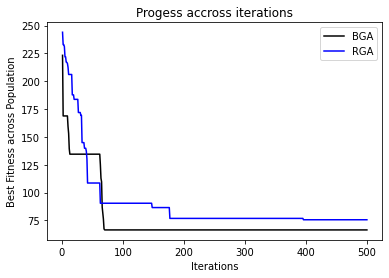

In [125]:
plt.figure()
plt.plot(np.arange(T)+1,bgafit,"-k")
plt.plot(np.arange(T)+1,rgafit,"-b")
plt.legend(["BGA","RGA"]);
plt.title("Progess accross iterations")
plt.xlabel("Iterations")
plt.ylabel("Best Fitness across Population")